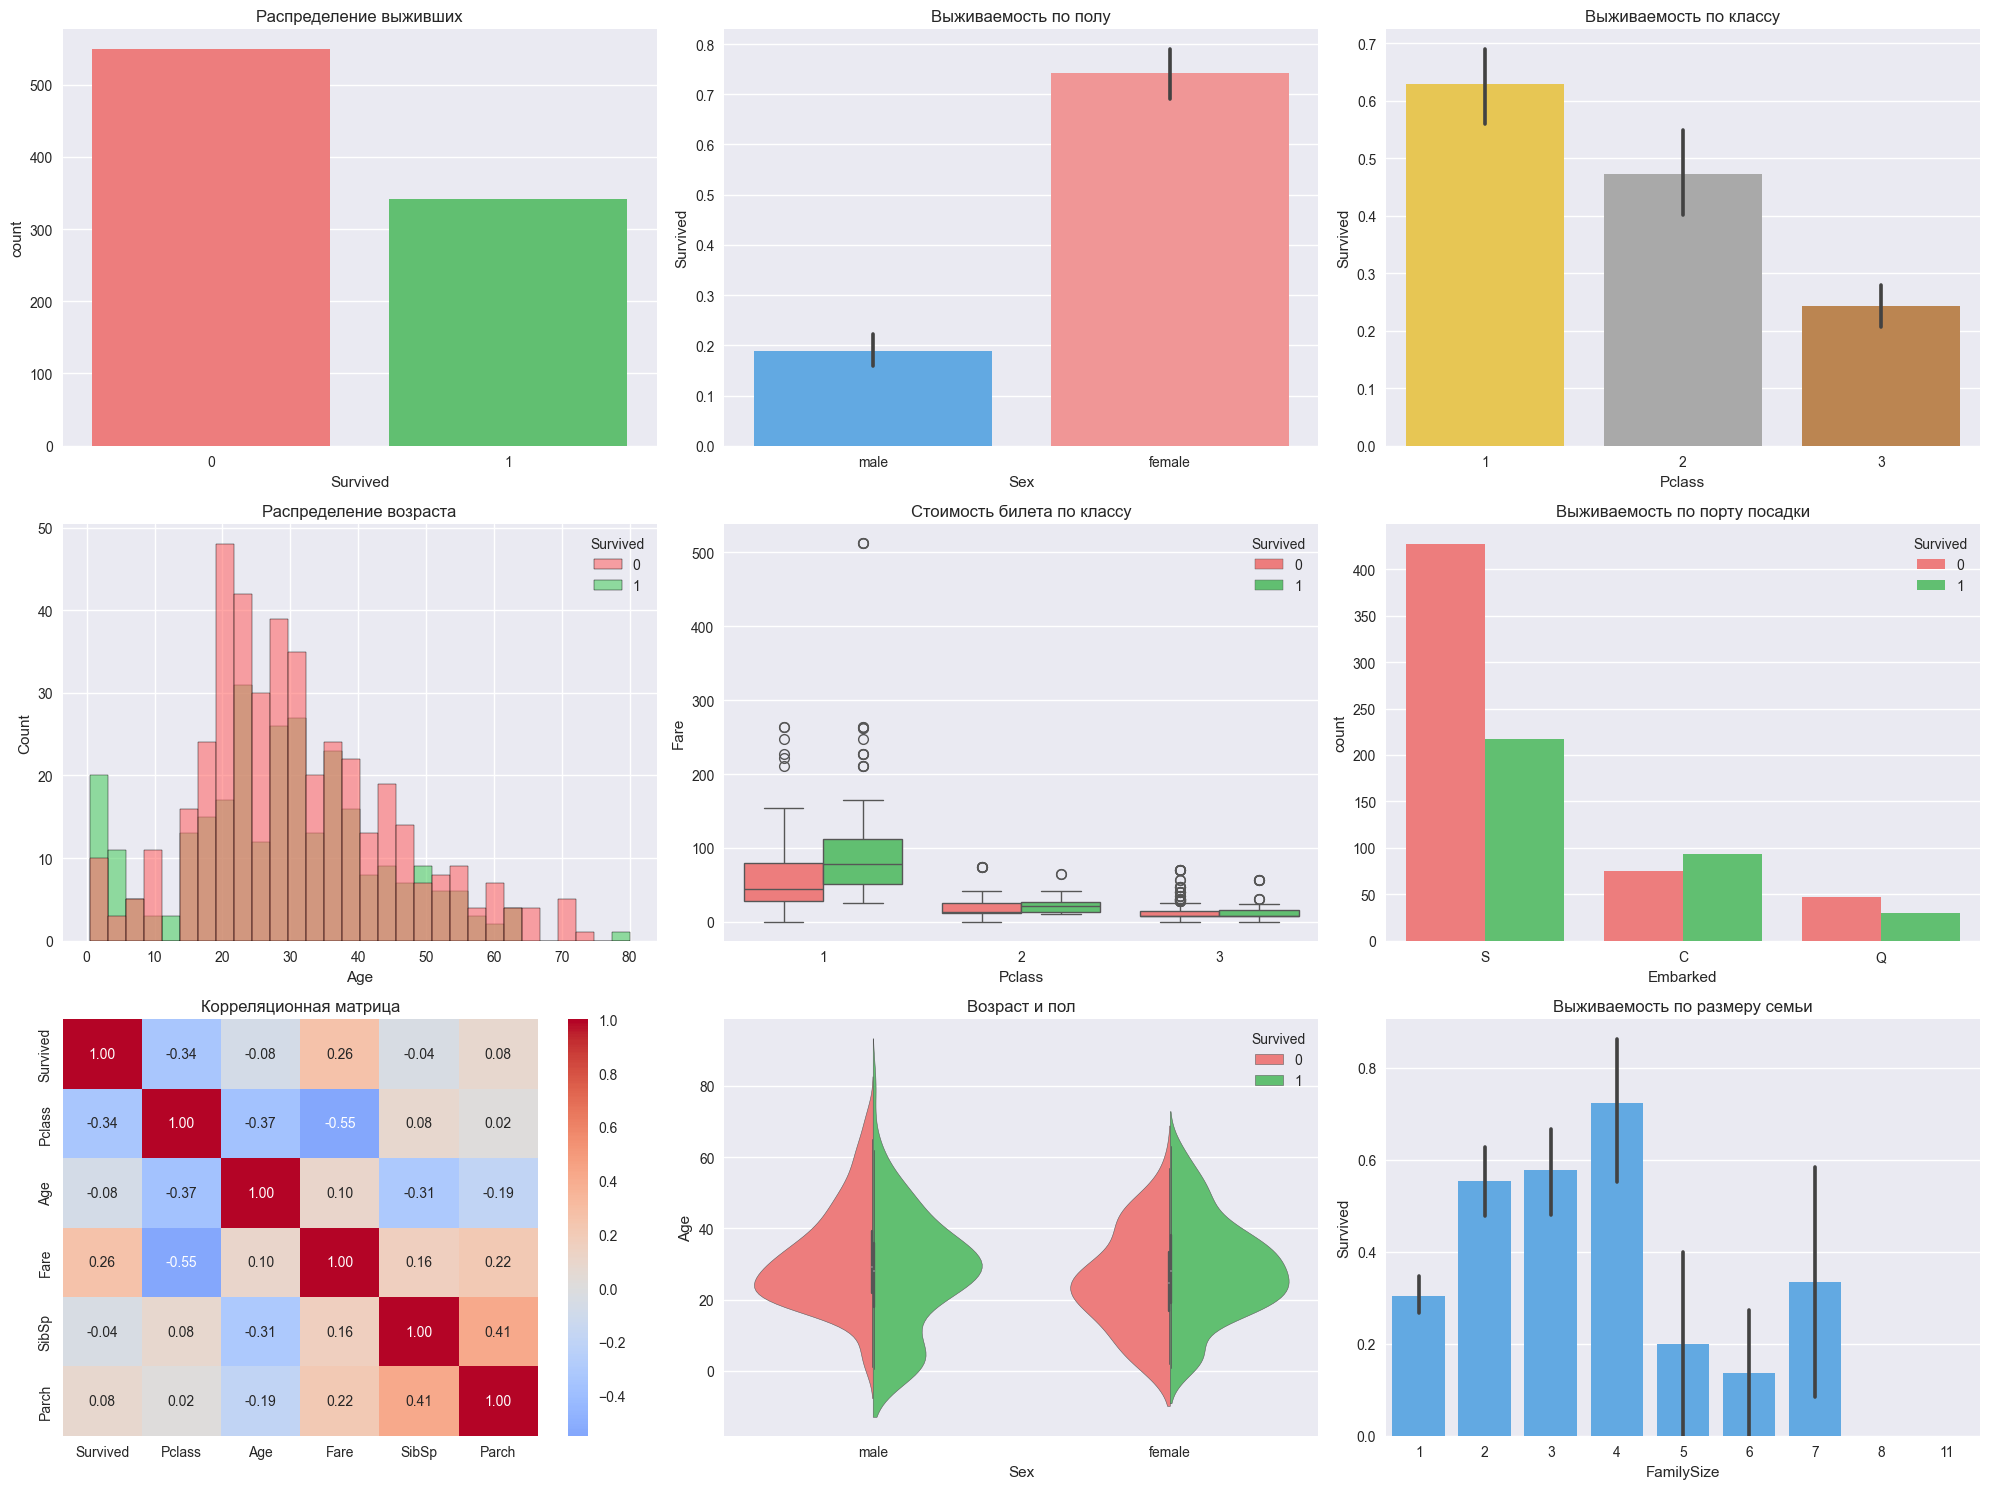

Features: 13, X_train: (891, 13), X_test: (418, 13)

🔹 Логистическая_регрессия...
   Validation Accuracy: 0.8156
   CV Mean: 0.8070 (+/- 0.0149)

🔹 Случайный_лес...
   Validation Accuracy: 0.7933
   CV Mean: 0.8260 (+/- 0.0148)

🔹 Градиентный_бустинг...
   Validation Accuracy: 0.8101
   CV Mean: 0.8395 (+/- 0.0164)

🔹 Линейный_SVC...
   Validation Accuracy: 0.8156
   CV Mean: 0.8092 (+/- 0.0181)

🔹 Наивный_Байес...
   Validation Accuracy: 0.7765
   CV Mean: 0.7890 (+/- 0.0142)

🔹 K_Соседи...
   Validation Accuracy: 0.7877
   CV Mean: 0.8069 (+/- 0.0106)

🔹 SVC_RBF...
   Validation Accuracy: 0.8101
   CV Mean: 0.8215 (+/- 0.0158)

🔹 AdaBoost...
   Validation Accuracy: 0.8045
   CV Mean: 0.8227 (+/- 0.0137)

🔹 Voting_Ensemble...
   Validation Accuracy: 0.8436
   CV Mean: 0.8417 (+/- 0.0121)

📊 РЕЗУЛЬТАТЫ МОДЕЛЕЙ
                model_name  val_accuracy    val_f1   cv_mean    cv_std
0          Voting_Ensemble      0.843575  0.787879  0.841743  0.012096
1      Градиентный_бустинг      0.81

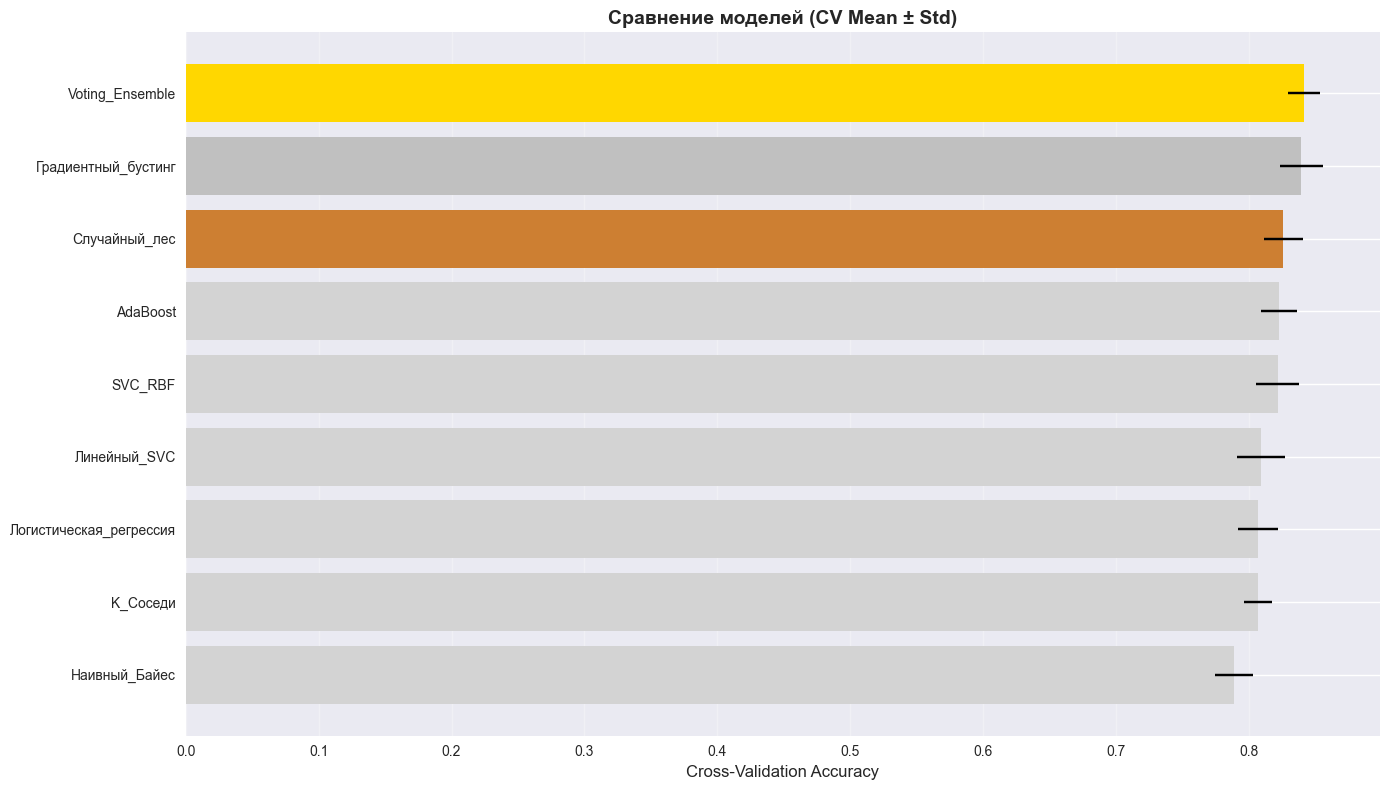


📤 SUBMISSION СОЗДАН
Лучшая модель: Логистическая_регрессия
CV Score: 0.8070
Файл: ../submissions/submission.csv


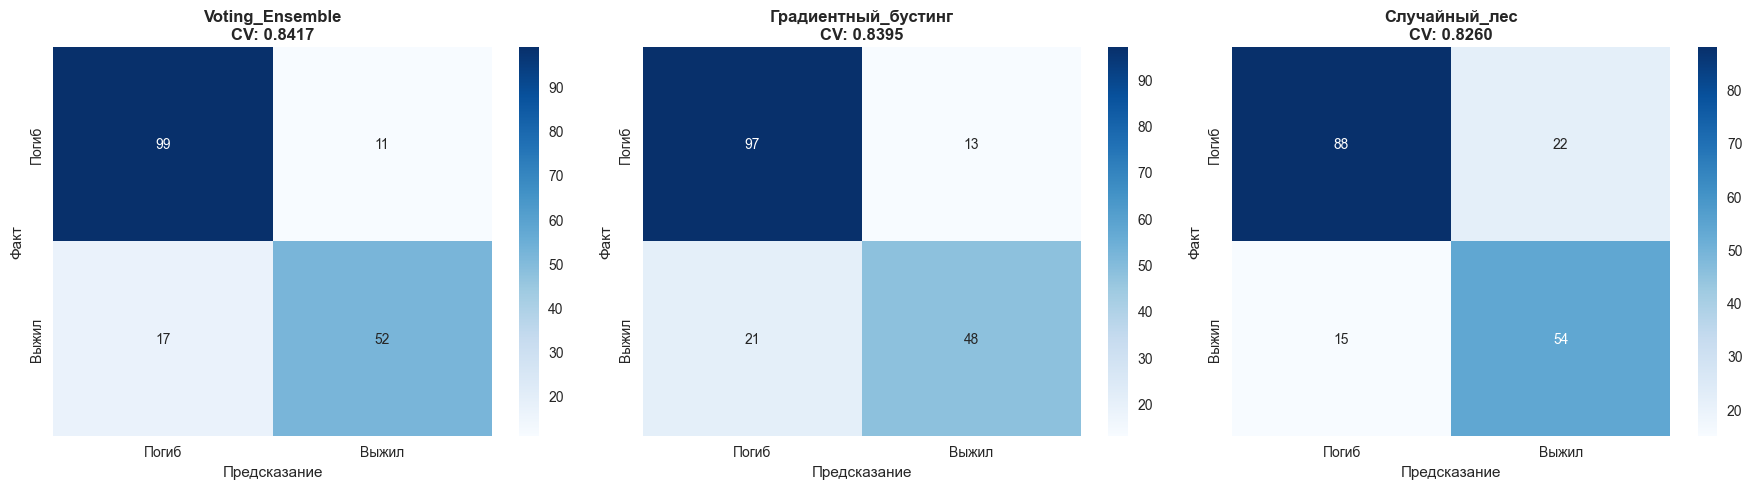


📈 ДЕТАЛЬНЫЕ МЕТРИКИ ЛУЧШЕЙ МОДЕЛИ
              precision    recall  f1-score   support

       Погиб       0.88      0.81      0.84       110
       Выжил       0.73      0.83      0.78        69

    accuracy                           0.82       179
   macro avg       0.81      0.82      0.81       179
weighted avg       0.82      0.82      0.82       179


✅ ОБРАБОТКА ЗАВЕРШЕНА


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import warnings
warnings.filterwarnings('ignore')

# Загрузка данных
train = pd.read_csv('../data/raw/train.csv')
test = pd.read_csv('../data/raw/test.csv')

# EDA
plt.style.use('seaborn-v0_8')
fig = plt.figure(figsize=(20, 15))
plt.subplot(3, 3, 1)
sns.countplot(data=train, x='Survived', palette=['#ff6b6b', '#51cf66'])
plt.title('Распределение выживших')
plt.subplot(3, 3, 2)
sns.barplot(data=train, x='Sex', y='Survived', palette=['#4dabf7', '#ff8787'])
plt.title('Выживаемость по полу')
plt.subplot(3, 3, 3)
sns.barplot(data=train, x='Pclass', y='Survived', palette=['#ffd43b', '#a9a9a9', '#cd853f'])
plt.title('Выживаемость по классу')
plt.subplot(3, 3, 4)
sns.histplot(data=train, x='Age', hue='Survived', bins=30, palette=['#ff6b6b', '#51cf66'], alpha=0.6)
plt.title('Распределение возраста')
plt.subplot(3, 3, 5)
sns.boxplot(data=train, x='Pclass', y='Fare', hue='Survived', palette=['#ff6b6b', '#51cf66'])
plt.title('Стоимость билета по классу')
plt.subplot(3, 3, 6)
sns.countplot(data=train, x='Embarked', hue='Survived', palette=['#ff6b6b', '#51cf66'])
plt.title('Выживаемость по порту посадки')
plt.subplot(3, 3, 7)
sns.heatmap(train[['Survived', 'Pclass', 'Age', 'Fare', 'SibSp', 'Parch']].corr(), annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Корреляционная матрица')
plt.subplot(3, 3, 8)
sns.violinplot(data=train, x='Sex', y='Age', hue='Survived', split=True, palette=['#ff6b6b', '#51cf66'])
plt.title('Возраст и пол')
family_data = train.copy()
family_data['FamilySize'] = family_data['SibSp'] + family_data['Parch'] + 1
plt.subplot(3, 3, 9)
sns.barplot(data=family_data, x='FamilySize', y='Survived', color='#4dabf7')
plt.title('Выживаемость по размеру семьи')
plt.tight_layout()
plt.savefig('../outputs/eda_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

# Предобработка
def preprocess_data(train_df, test_df):
    train = train_df.copy()
    test = test_df.copy()
    
    for df in [train, test]:
        df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
        df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
        df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
        rare_titles = ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
        df['Title'] = df['Title'].replace(rare_titles, 'Rare')
        df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
        df['Title'] = df['Title'].replace('Mme', 'Mrs')
        df['Age'] = df.groupby('Title')['Age'].transform(lambda x: x.fillna(x.median()))
        df['Age'].fillna(df['Age'].median(), inplace=True)
        df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
        df['Fare'].fillna(df['Fare'].median(), inplace=True)
        df['HasCabin'] = df['Cabin'].notna().astype(int)
        df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
        df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
        df['AgeBin'] = pd.cut(df['Age'], bins=[0, 12, 20, 40, 60, 100], labels=[0, 1, 2, 3, 4], include_lowest=True).fillna(0).astype(int)
        df['FareBin'] = pd.cut(df['Fare'], bins=[0, 7, 14, 31, 60, 600], labels=[0, 1, 2, 3, 4], include_lowest=True).fillna(0).astype(int)
    
    title_mapping = {'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3, 'Rare': 4}
    for df in [train, test]:
        df['Title'] = df['Title'].map(title_mapping).fillna(0)
    
    features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'IsAlone', 'Title', 'HasCabin', 'AgeBin', 'FareBin']
    
    X_train = train[features]
    y_train = train['Survived']
    X_test = test[features]
    test_ids = test['PassengerId']
    
    # Финальная очистка NaN
    for col in X_train.columns:
        if X_train[col].dtype in ['float64', 'int64']:
            median_val = X_train[col].median()
            X_train[col] = X_train[col].fillna(median_val)
            X_test[col] = X_test[col].fillna(median_val)
    
    return X_train, y_train, X_test, test_ids, features

X_train, y_train, X_test, test_ids, features = preprocess_data(train, test)
print(f"Features: {len(features)}, X_train: {X_train.shape}, X_test: {X_test.shape}")

# Масштабирование
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Разделение
X_tr, X_val, y_tr, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Модели
models = {
    'Логистическая_регрессия': LogisticRegression(max_iter=1000, random_state=42, C=0.5, class_weight='balanced'),
    'Случайный_лес': RandomForestClassifier(n_estimators=200, max_depth=6, min_samples_split=5, random_state=42, class_weight='balanced'),
    'Градиентный_бустинг': GradientBoostingClassifier(n_estimators=150, max_depth=4, learning_rate=0.1, min_samples_split=5, random_state=42),
    'Линейный_SVC': LinearSVC(max_iter=1000, random_state=42, C=0.5, class_weight='balanced'),
    'Наивный_Байес': GaussianNB(),
    'K_Соседи': KNeighborsClassifier(n_neighbors=7, weights='distance', metric='euclidean'),
    'SVC_RBF': SVC(kernel='rbf', probability=True, random_state=42, C=1.0, gamma='scale', class_weight='balanced'),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, learning_rate=0.5, random_state=42),
    'Voting_Ensemble': VotingClassifier(estimators=[
        ('rf', RandomForestClassifier(n_estimators=200, max_depth=6, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=150, max_depth=4, learning_rate=0.1, random_state=42)),
        ('svc', SVC(kernel='rbf', probability=True, random_state=42, C=1.0)),
        ('lr', LogisticRegression(max_iter=1000, random_state=42, C=0.5))
    ], voting='soft')
}

# Обучение
results = []
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\n🔹 {name}...")
    model.fit(X_tr, y_tr)
    y_pred_val = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_pred_val)
    val_f1 = f1_score(y_val, y_pred_val)
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv_strategy, scoring='accuracy')
    y_pred_test = model.predict(X_test_scaled)
    
    results.append({
        'model_name': name, 'model': model, 'val_accuracy': val_accuracy,
        'val_f1': val_f1, 'cv_mean': cv_scores.mean(), 'cv_std': cv_scores.std(),
        'predictions': y_pred_test
    })
    print(f"   Validation Accuracy: {val_accuracy:.4f}")
    print(f"   CV Mean: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# Результаты
results_df = pd.DataFrame(results)
results_df = results_df[['model_name', 'val_accuracy', 'val_f1', 'cv_mean', 'cv_std']]
results_df = results_df.sort_values('cv_mean', ascending=False).reset_index(drop=True)

print("\n" + "="*80)
print("📊 РЕЗУЛЬТАТЫ МОДЕЛЕЙ")
print("="*80)
print(results_df.to_string(index=True))

top3 = results_df.head(3)
print("\n" + "🎯"*30)
print("🏆 ТОП-3 ЛУЧШИХ МОДЕЛЕЙ")
print("🎯"*30)
for i, row in top3.iterrows():
    print(f"\n{i+1} место: {row['model_name']}")
    print(f"   Cross-Validation: {row['cv_mean']:.4f} (+/- {row['cv_std']:.4f})")
    print(f"   Validation Accuracy: {row['val_accuracy']:.4f}")
    print(f"   Validation F1-Score: {row['val_f1']:.4f}")

# Визуализация сравнения моделей
plt.figure(figsize=(14, 8))
# Исправлено: bronze заменен на #CD7F32 (hex код бронзы)
colors = ['gold', 'silver', '#CD7F32'] + ['lightgray'] * (len(results_df) - 3)
bars = plt.barh(results_df['model_name'], results_df['cv_mean'], xerr=results_df['cv_std'], color=colors, capsize=5)
plt.xlabel('Cross-Validation Accuracy', fontsize=12)
plt.title('Сравнение моделей (CV Mean ± Std)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('../outputs/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Submission
best_model_idx = results_df['cv_mean'].idxmax()
best_model_info = results[best_model_idx]
best_model = best_model_info['model']

final_predictions = best_model.predict(X_test_scaled)
submission = pd.DataFrame({'PassengerId': test_ids, 'Survived': final_predictions.astype(int)})
submission.to_csv('../submissions/submission.csv', index=False)

print("\n" + "="*80)
print("📤 SUBMISSION СОЗДАН")
print("="*80)
print(f"Лучшая модель: {best_model_info['model_name']}")
print(f"CV Score: {best_model_info['cv_mean']:.4f}")
print(f"Файл: ../submissions/submission.csv")

# Матрицы ошибок для ТОП-3
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (i, row) in enumerate(top3.iterrows()):
    model_name = row['model_name']
    
    # Найти модель в results по имени
    model_info = None
    for result in results:
        if result['model_name'] == model_name:
            model_info = result
            break
    
    model = model_info['model']
    y_pred = model.predict(X_val)
    cm = confusion_matrix(y_val, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], 
                xticklabels=['Погиб', 'Выжил'], yticklabels=['Погиб', 'Выжил'])
    axes[idx].set_title(f'{model_name}\nCV: {row["cv_mean"]:.4f}', fontweight='bold')
    axes[idx].set_xlabel('Предсказание')
    axes[idx].set_ylabel('Факт')

plt.tight_layout()
plt.savefig('../outputs/confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()
# Детальные метрики
print("\n" + "="*80)
print("📈 ДЕТАЛЬНЫЕ МЕТРИКИ ЛУЧШЕЙ МОДЕЛИ")
print("="*80)
y_pred_best = best_model.predict(X_val)
print(classification_report(y_val, y_pred_best, target_names=['Погиб', 'Выжил']))
print("\n✅ ОБРАБОТКА ЗАВЕРШЕНА")